## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?


### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [0]:
# Import external libraries:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, ttest_1samp, t, norm
import scipy.stats as stats

# Load in csv file of house votes from '84:
house_votes = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data', header=None, na_values='?')

# Check to see if the data loades with the frist 5 rows:
# display(house_votes.head())

# View the shape of our data to see if it matches the original data repo:
# print(house_votes.shape)

# Open the names document to get the attribute names
import requests
names = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.names').text
#print(names)


# Create a list of Attribute names to use as columns:
cols = ['party','handicap-infants','water-project-cost-sharing',
        'adoption-of-the-budget-resolution','physician-fee-freeze',
        'el-salvador-aid','religious-groups-in-schools',
        'anti-satellite-test-ban','aid-to-nicaraguan-contras','mx-missile',
        'immigration','synfuels-corporation','education-spending',
        'superfund-right-to-sue','crime','duty-free-exports',
        'export-administration-act-south-africa']

# Apply cols list to our data frame:
house_votes.columns = cols

# View the first five rows to confirm the change was saved:
# house_votes.head()

# Here we will map our yes and no values:
house_votes = house_votes.replace({'y':1,'n':0})

# Now I want to create a group for republicans and a group ro democrats:
republicans = house_votes[house_votes['party']=='republican']
democrats = house_votes[house_votes['party']=='democrat']

In [3]:
# get the mean of both republicans and democrats.
print(republicans['religious-groups-in-schools'].mean())
print(democrats['religious-groups-in-schools'].mean())

0.8975903614457831
0.47674418604651164


In [0]:
ttest_1samp(republicans['religious-groups-in-schools'],
            house_votes['religious-groups-in-schools'].mean(),nan_policy='omit')

Ttest_1sampResult(statistic=10.84949937999739, pvalue=4.850660006171671e-21)

In [0]:
# is there a significant difference in votes for religious groups in schools  among republicans 
results = ttest_ind(republicans['religious-groups-in-schools'],democrats['religious-groups-in-schools'],nan_policy='omit')
results

Ttest_indResult(statistic=9.737575825219457, pvalue=2.3936722520597287e-20)

In [0]:
# useing a crosstab to further examine data
rep_dem_x = pd.crosstab(house_votes['party'],house_votes['religious-groups-in-schools'],normalize='index')
rep_dem_x

religious-groups-in-schools,0.0,1.0
party,,
democrat,0.523256,0.476744
republican,0.102410,0.897590


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


>  <b>Confidence Interval Formula:</b>
$\bar{X}\pm{t}\frac{S}{\sqrt{n}}$

In [0]:
def confidence_interval(data,confidence=0.95):
    data = np.array(data) # convert data to array
    x_bar = np.mean(data) # get the mean of the data
    n = len(data) # length of the sample
    std_err = np.std(data, ddof=1)/np.sqrt(n) # get the standard error
    moe = std_err * stats.t.ppf((1 + confidence) / 2.0, n - 1) 
    return (x_bar, x_bar - moe, x_bar + moe)

In [0]:
# Use our confidence_interval function to get the mean, upper bounds, and lower bounds.
# save each output to its own variable.
mu,upper_bound,lower_bound = confidence_interval(republicans['religious-groups-in-schools'].dropna())
print('Mean: ',mu)
print('Upper bounds',upper_bound)
print('Lower bounds',lower_bound)

Mean:  0.8975903614457831
Upper bounds 0.850987486003394
Lower bounds 0.9441932368881721


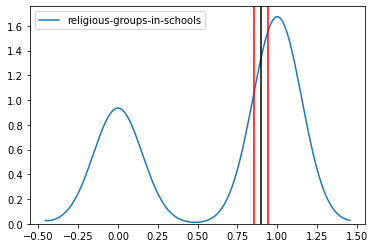

In [0]:
# Plot the confidence interval of republicans voting yes on religious groups in schools.
sns.kdeplot(house_votes['religious-groups-in-schools'])
plt.axvline(x=upper_bound,color='red')
plt.axvline(x=lower_bound,color='red')
plt.axvline(x=mu,color='k');

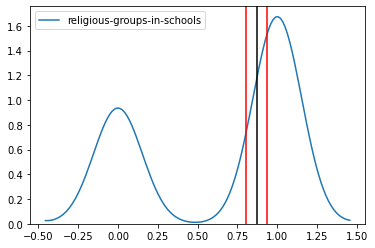

In [0]:
# drop my na values
republicans_na = republicans.dropna()

# get confidence intervals for how the repulican are likly to vote on the topic
# use the stats.t.interval to get the confidence interval instead of writing our own function
conf_int = stats.t.interval(0.95, # alpha (confidence level)
                            republicans_na.shape[0], # length of sample
                            loc = republicans_na['religious-groups-in-schools'].mean(), # mu (i.e., the mean)
                            scale = stats.sem(republicans_na['religious-groups-in-schools'])) # the std error of mu

# Display our confidence intervals
conf_int

# plot thes results on a graph
sns.kdeplot(house_votes['religious-groups-in-schools'])
plt.axvline(x=conf_int[0],color='red')
plt.axvline(x=conf_int[1],color='red')
plt.axvline(x=republicans_na['religious-groups-in-schools'].mean(),color='k');

In [0]:
republicans_na.shape

(108, 17)

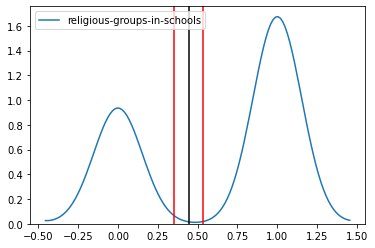

In [0]:
# drop my na values from the democrats dataset
democrats_na = democrats.dropna()

# Get confidence interval on how democrats are more likely to vote. 
# use the stats.t.interval to get the confidence interval instead of writing our own function
conf_int = stats.t.interval(0.95, # alpha (confidence level)
                            democrats_na.shape[0], # length of sample
                            loc = democrats_na['religious-groups-in-schools'].mean(), # mu (i.e., the mean)
                            scale = stats.sem(democrats_na['religious-groups-in-schools'])) # the std error of mu

# Display our confidence intervals
conf_int

# plot thes results on a graph
sns.kdeplot(house_votes['religious-groups-in-schools'])
plt.axvline(x=conf_int[0],color='red')
plt.axvline(x=conf_int[1],color='red')
plt.axvline(x=democrats_na['religious-groups-in-schools'].mean(),color='k');

In [0]:
democrats_na.shape

(124, 17)



---



---



---



---



In [4]:
# Take a look at the Ames Iowa Housing Dataset:
src_url = 'https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv'

# Read the data file from the src_url variable into a pandas DataFrame
iowa_housing_df = pd.read_csv(src_url)

# Display the first 10 rows to see if the DataFrame was made
print("Top 10 Rows of iowa_housing_df: ")
display(iowa_housing_df.head(20))

# Display the shape of iowa_housing_df
print("\niowa_housing_df shape: ")
display(iowa_housing_df.shape)

Top 10 Rows of iowa_housing_df: 


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,...,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,...,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,...,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,...,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,


iowa_housing_df shape: 


(1460, 81)

In [0]:
sale = pd.cut(iowa_housing_df['SalePrice'],
       [50000,100000,300000,500000],
       labels=['low','mid','high'])
year = pd.cut(iowa_housing_df['YearBuilt'],
              [1900,1970,2010],
              labels=['old','new'])
cond = pd.cut(iowa_housing_df['OverallCond'],
              [1,3,6,9],
              labels=['poor','good','great'])

In [43]:
ob_all = pd.crosstab(cond,sale,margins=True)

row_sums = ob_all.iloc[:3, 3].values
col_sums = ob_all.iloc[3, 0:3].values

total = ob_all.loc['All','All']

expected = []
for i in range(len(row_sums)):
    expected_row = []
    for column in col_sums:
        expected_val = column*row_sums[i]/total
        expected_row.append(expected_val)
    expected.append(expected_row)
    
expected = np.array(expected)

ob = pd.crosstab(cond,sale).values

chi_squared_by_hand = ((ob - expected)**2 / (expected)).sum()

deg_of_freedom = (len(row_sums)-1)*(len(col_sums)-1)

print("chi-squared stat: ",chi_squared_by_hand)
print("Degrees of Freedom: ",deg_of_freedom)
print("Expected: \n",np.array(expected))

chi-squared stat:  130.60097455611262
Degrees of Freedom:  4
Expected: 
 [[  2.26712803  23.67889273   2.05397924]
 [ 90.52318339 945.46435986  82.01245675]
 [ 24.20968858 252.8567474   21.93356401]]


SalePrice,low,mid,high
OverallCond,,,
poor,18,9,1
good,79,944,95
great,20,269,10


130.60097455611262
2.896512651901398e-27
4
[[  2.26712803  23.67889273   2.05397924]
 [ 90.52318339 945.46435986  82.01245675]
 [ 24.20968858 252.8567474   21.93356401]]


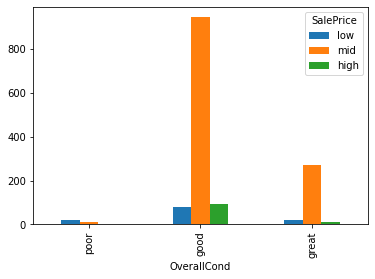

In [44]:
ob1 = pd.crosstab(cond,sale)
ob1.plot.bar()
display(ob1)

chi_squared, p_val, dof, expected = stats.chi2_contingency(ob1)
print(chi_squared)
print(p_val)
print(dof)
print(np.array(expected))

SalePrice,low,mid,high
YearBuilt,,,
old,94,554,6
new,18,651,98


132.61704281971947
1.5943183641083555e-29
2
[[ 51.54679803 554.58831809  47.86488388]
 [ 60.45320197 650.41168191  56.13511612]]


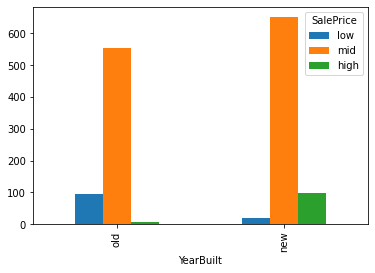

In [7]:
ob2 = pd.crosstab(year,sale)
ob2.plot.bar()
display(ob2)

chi_squared, p_val, dof, expected = stats.chi2_contingency(ob2)
print(chi_squared)
print(p_val)
print(dof)
print(np.array(expected))

## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)